# Import Libraries

In [30]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split , RandomizedSearchCV , GridSearchCV , cross_val_score
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier , ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier

import warnings
warnings.simplefilter("ignore")


## Load the data

In [31]:
df = pd.read_csv("water_potability.csv")
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [32]:
# Check the shape of data
df.shape

(3276, 10)

## Exploratory Data Analysis (EDA)

In [33]:
# checking data types
df.dtypes

ph                 float64
Hardness           float64
Solids             float64
Chloramines        float64
Sulfate            float64
Conductivity       float64
Organic_carbon     float64
Trihalomethanes    float64
Turbidity          float64
Potability           int64
dtype: object

In [34]:
# check the Nan Values
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

So There is lot of Nan Values in ph , Sulfate etc so we must do some further analysis to figure out what we must replace that data with.

39.01 % of samples are potable (1)


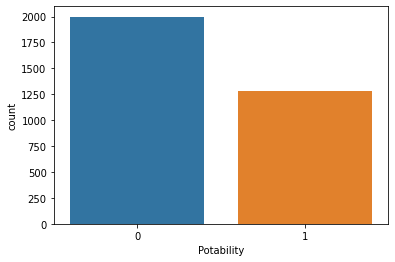

In [35]:
# Count Distribution of target variable
sns.countplot(x = df["Potability"])

print(f"{df.Potability[df.Potability==1].count() / df.Potability.count()*100:.2f} % of samples are potable (1)")

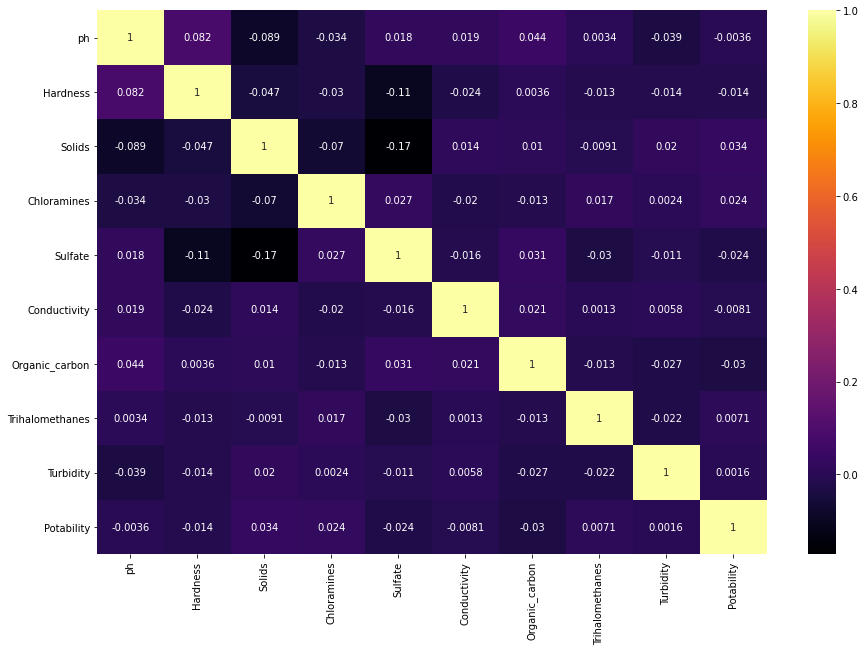

In [36]:
# Correlation matrix for dataset
plt.figure(figsize=(15,10))
sns.heatmap(df.corr() , annot=True , cmap="inferno");

Correlation matrix shows weak correlation between features suggesting that they are reasonably independent of eachother. There is no multicollinearity.

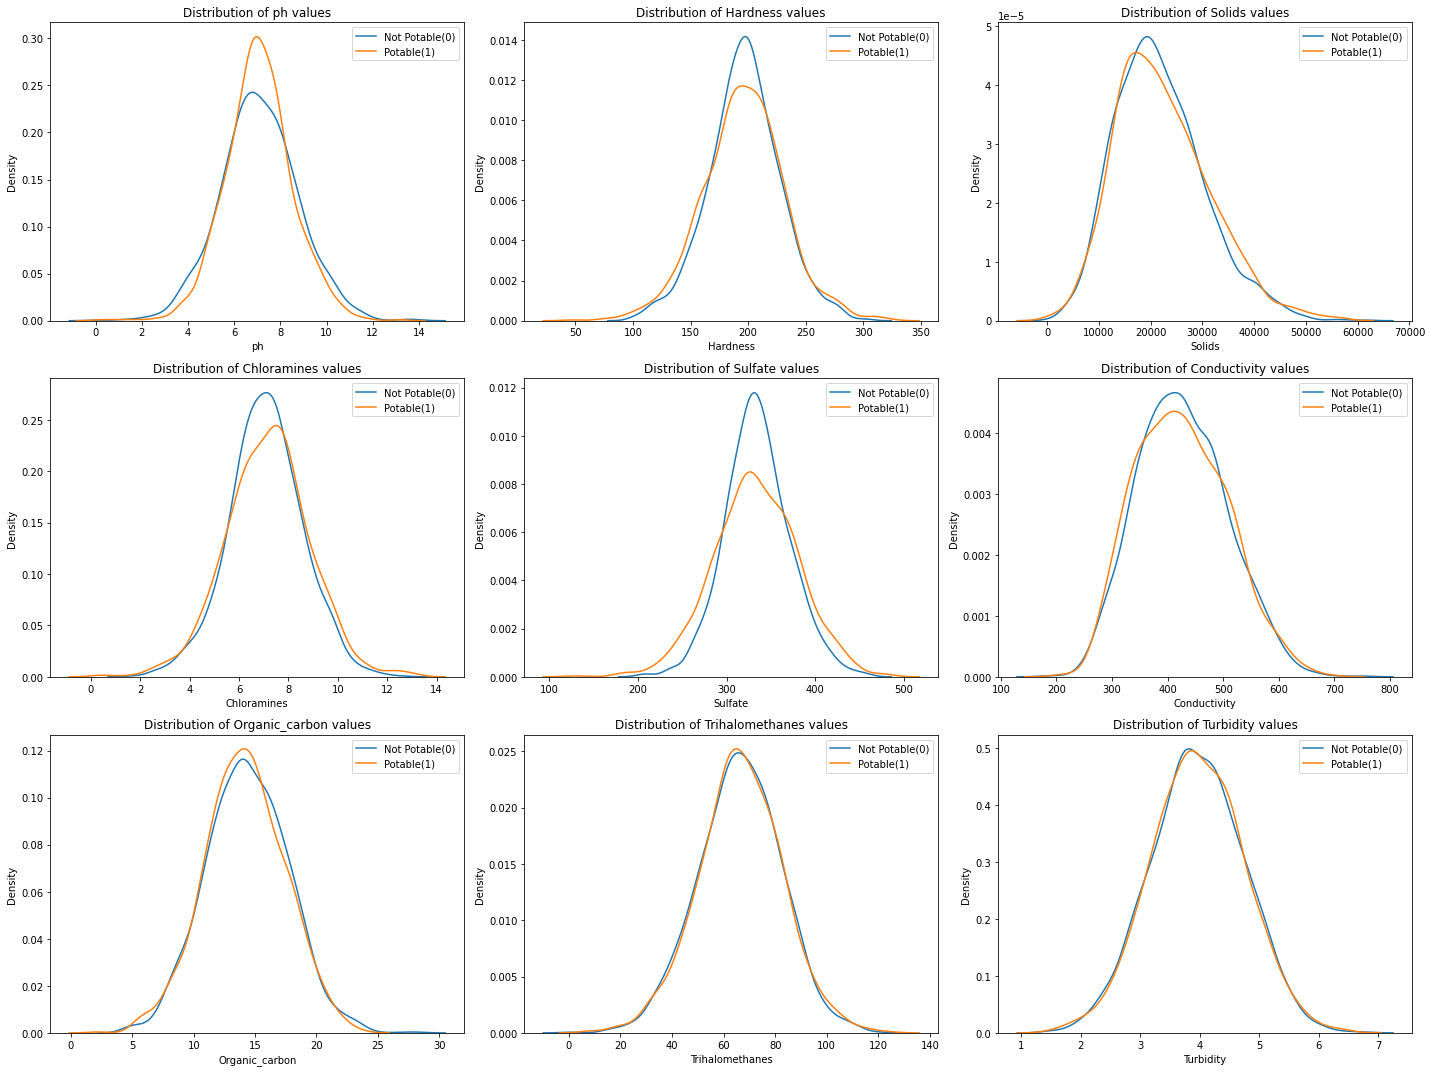

In [37]:
# Distribution of features
potable = df.query("Potability == 1")
not_potable = df.query("Potability == 0")

fig = plt.figure(figsize=(20,15))

for ax , column in enumerate(df.columns[:9]):
    plt.subplot(3 , 3 , ax+1)
    plt.title(f"Distribution of {column} values")
    sns.kdeplot(x = not_potable[column] , label = "Not Potable(0)")
    sns.kdeplot(x = potable[column] , label = "Potable(1)")
    plt.legend(prop = dict(size = 10))


plt.tight_layout()

In [38]:
fig = plt.figure(figsize=(20,15))

for ax , column in enumerate(df.columns[:9]):
    plt.subplot(3 ,3 , ax+1)
    plt.title(f"Disribution of {column} values")
    sns.distplot(not_potable[column] , label="Not Potable(0)", hist_kws=dict(edgecolor = "k" , linewidth = 1), bins=25)
    sns.distplot(potable[column], label='Potable(1)', hist_kws=dict(edgecolor='k', linewidth=1), bins=25)
    plt.legend(prop = dict(size = 10))

plt.tight_layout()

Data shows reasonably normal distribution for all features.



## Handle the missing data

In [ ]:
def impute_nan(df , variable):
    df[variable] = df[variable].fillna(df[variable].mean())

impute_nan(df , "ph")
impute_nan(df , "Sulfate")
impute_nan(df , "Trihalomethanes")

In [ ]:
df.isnull().sum()

Finally all the missing values are handled.

## Split , Balance and Scaling the data

In [ ]:
# Split into dependent and independent feature
X = df.drop("Potability" , axis=1)
y = df.Potability

# Split into train and test dataset
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.25 , random_state=18 , stratify=y)

# Balancing the data
smt = SMOTE()
X_train , y_train = smt.fit_resample(X_train , y_train)

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
X_train.shape , y_train.shape

## Build and Train the model

we will try multiple Algorithms and see which one is give better result

 - Logistic Regression
 - K-Nearest Neighbors
 - Random Forest Classifier
 - Decision Tree Classifier
 - Naive Bayes
 - ExtraTreesClassifier
 - XGB Classifier
 - CatBoostClassifier


In [ ]:
# Put models in a dictionary

models = {"Logistic Regression": LogisticRegression(),
         "KNN": KNeighborsClassifier(),
         "Random Forest": RandomForestClassifier(),
         "Decision Tree": DecisionTreeClassifier(),
         "Naive Bayes": GaussianNB(),
         "ExtraTreesClassifier": ExtraTreesClassifier(),
         "xgb Classifier": XGBClassifier(),
         "CatBoostClassifier": CatBoostClassifier()}



In [ ]:
# Create a function to fit and score models
def fit_and_score(models , X_train , X_test , y_train , y_test):

    """
   Fits and evaluates given machine learning models.
   models: a dict of different Scikit_Learn machine learning models
   X_train: training data (no labels)
   X_test: testing data (no labels)
   y_train: training labels
   y_test: test labels
   """ 

    # Set random seed
    np.random.seed(18)

    # Make a dictionary to keep model scores
    model_scores = {}

    # loop through models
    for name , model in models.items():
        # fit model to data
        model.fit(X_train , y_train)
        # Evaluate model and append its score to model_scores
        model_scores[name] = cross_val_score(model,
                                            X_test,
                                            y_test,
                                            scoring="accuracy",
                                            cv = 5).mean()

    return model_scores



In [ ]:
model_scores = fit_and_score(models , X_train , X_test , y_train , y_test)
model_scores